# Unlocking Church Growth: Data Insights from the National Congregations Study
# Music Analysis

## Objective
In this segment of the analysis we specifically explore the features associated to Music at the congregation and how they may impact an attendance change. The features included are:<br>
 - Singing: by the congregation during the worship service
 - Choir: was involved in the worship service
 - Piano: was used during the worship service
 - Organ: was used during the worship service
 - Drums: were used during the worship service
 - Electric Guitar: was used during the worship service
 - Guitar: an acustic guitar was used during the worship service

## Data Preparation

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from scipy.stats import spearmanr, pearsonr, chi2_contingency, fisher_exact
from scipy.stats.contingency import relative_risk
from scipy.stats.contingency import odds_ratio
from scipy.stats import f_oneway  # Inferential Analysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE # Rancom Forest oversampling


# Import DictionaryCollection class from Dictionaries.py
    # Download the file from GitHub
url = 'https://raw.githubusercontent.com/NRSchaaf/unlocking-church-growth/main/notebook/dictionaries.py'
response = requests.get(url)

    # Save the file locally
with open('dictionaries.py', 'wb') as file:
    file.write(response.content)
from dictionaries import dictionaryCollection

In [2]:
# Load Data
url = 'https://raw.githubusercontent.com/NRSchaaf/unlocking-church-growth/main/dataset/dataset.csv'
data = pd.read_csv(url)

In [3]:
# Initialize DictionaryCollection instance
dict_collection = dictionaryCollection()

# Replace numerical values column with string values from dictionaries
data = dict_collection.replace_numeric_values(data)

In [4]:
def set_seaborn_style(font_family, background_color, grid_color, text_color):
    sns.set_style({
        "axes.facecolor": background_color,
        "figure.facecolor": background_color,

        "grid.color": grid_color,
        "axes.edgecolor": grid_color,
        "axes.grid": True,
        "axes.axisbelow": True,
        
        "axes.labelcolor": text_color,
        "text.color": text_color,
        "font.family": font_family,
        "xtick.color": text_color,
        "ytick.color": text_color,

        "xtick.bottom": False,
        "xtick.top": False,
        "ytick.left": False,
        "ytick.right": False,

        "axes.spines.left": False,
        "axes.spines.bottom": True,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
)

background_color = "#006064"
grid_color = "#cccccc"
bar_color = "#009688"
text_color = "#ffffff"
font_family = "Arial"

set_seaborn_style(font_family, background_color, grid_color, text_color)

### Data Transformations

In [5]:
# Create new features based on conditions
data['change_category'] = data['CHANGE'].apply(
    lambda x: "Increase" if "Increased" in str(x) else ("Decrease" if "Decreased" in str(x) else ("Same" if "Same" in str(x) else "Same"))
)

# Change column data types
data['DENOM'] = data['DENOM'].astype('category')
data['change_category'] = data['change_category'].astype('category')

### Data Cleaning

In [6]:
# Select specific features
selected_columns = ['DENOM', 'SINGING', 'CHOIR', 'PIANO', 'ORGAN', 'DRUMS', 'ELECGTR', 'GUITAR', 'change_category']
df_music = data[selected_columns].copy()

In [7]:
# Drop DENOM
df_music.drop(['DENOM'], axis=1, inplace=True)

# One-Hot Encoding
categorical_columns = df_music.select_dtypes(include=['category']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_music[categorical_columns])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
#df_facilities_encoded = pd.concat([df_facilities.reset_index(drop=True), encoded_df], axis=1)
df_music_encoded = pd.concat([df_music, encoded_df], axis=1)
df_music_encoded = df_music_encoded.drop(categorical_columns, axis=1)

## Descriptive Analysis

In [8]:
# Basic exploration
df_music.info()
df_music.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   SINGING          5329 non-null   object  
 1   CHOIR            5328 non-null   object  
 2   PIANO            1190 non-null   object  
 3   ORGAN            3742 non-null   object  
 4   DRUMS            5205 non-null   object  
 5   ELECGTR          1163 non-null   object  
 6   GUITAR           4048 non-null   object  
 7   change_category  5333 non-null   category
dtypes: category(1), object(7)
memory usage: 297.1+ KB


,SINGING,CHOIR,PIANO,ORGAN,DRUMS,ELECGTR,GUITAR,change_category
count,5329,5328,1190,3742,5205,1163,4048,5333
unique,2,2,2,2,2,2,2,3
top,True,True,True,True,False,False,False,Same
freq,5207,3141,823,2214,3175,816,2184,4383


## Exploratory Data Analysis (EDA)
Correlation Analysis: Use correlation matrices to identify relationships between congregational offerings and attendance.<br>
Visualization: Create visualizations such as histograms, box plots, scatter plots, and heatmaps to explore patterns and trends.

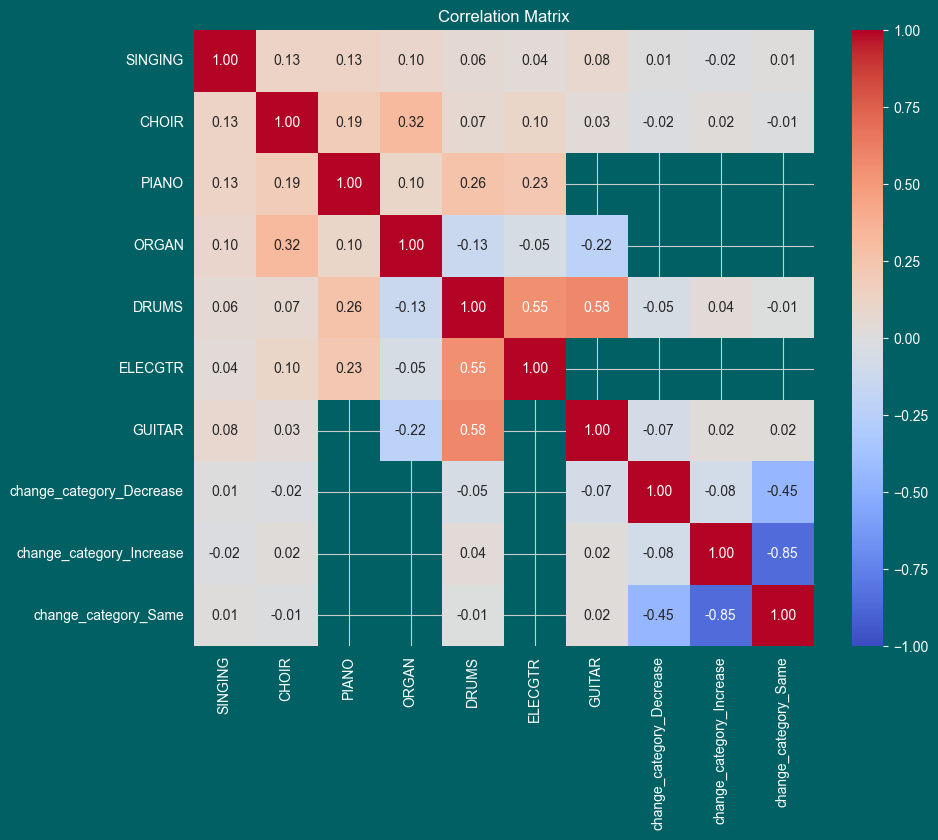

In [9]:
# Perform correlation analysis
correlation_matrix = df_music_encoded.corr()

plt.figure(figsize=(10,8))  # Adjust the figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Add plot title and show plot
plt.title('Correlation Matrix')
plt.show()

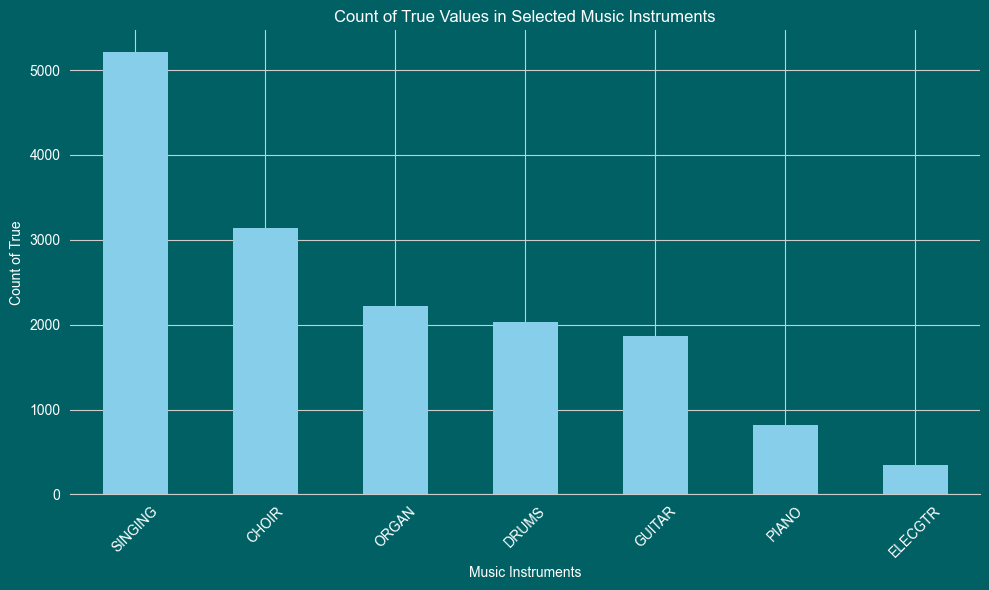

In [10]:
# Specify columns of interest
columns_of_interest = ['SINGING', 'CHOIR', 'PIANO', 'ORGAN', 'DRUMS', 'ELECGTR', 'GUITAR']

# Calculate counts of True values for specified columns
true_counts = df_music[columns_of_interest].sum().sort_values(ascending=False)

# Plotting bar graph
plt.figure(figsize=(10, 6))
true_counts.plot(kind='bar', color='skyblue')

# Adding labels and title
plt.xlabel('Music Instruments')
plt.ylabel('Count of True')
plt.title('Count of True Values in Selected Music Instruments')

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

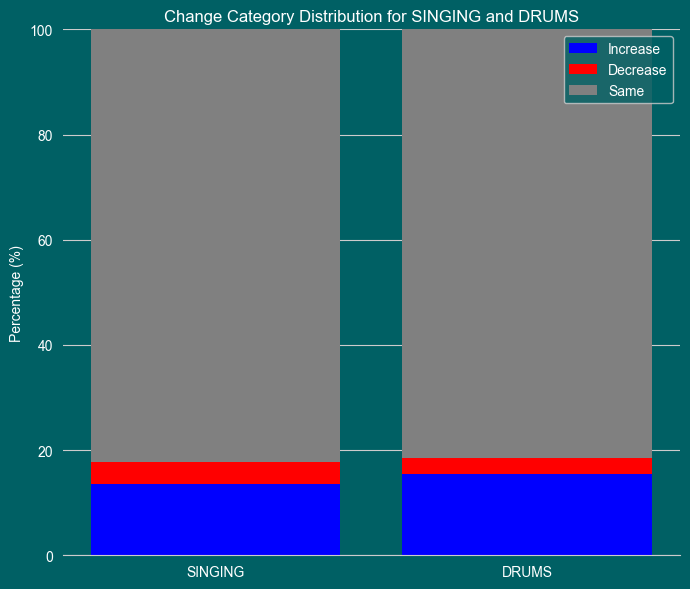

In [11]:
# Calculate the prevalence
total_count = len(df_music)
singing_count = df_music['SINGING'].sum()
drums_count = df_music['DRUMS'].sum()
singing_percentage = (singing_count / total_count) * 100
drums_percentage = (drums_count / total_count) * 100

# Calculate the distribution of change_category for SINGING and DRUMS
singing_distribution = df_music[df_music['SINGING'] == True]['change_category'].value_counts(normalize=True) * 100
drums_distribution = df_music[df_music['DRUMS'] == True]['change_category'].value_counts(normalize=True) * 100

# Visualize the distribution of change_category
fig2, ax2 = plt.subplots(figsize=(7, 6))

singing_increase = singing_distribution.get('Increase', 0)
singing_decrease = singing_distribution.get('Decrease', 0)
singing_same = singing_distribution.get('Same', 0)

drums_increase = drums_distribution.get('Increase', 0)
drums_decrease = drums_distribution.get('Decrease', 0)
drums_same = drums_distribution.get('Same', 0)

ax2.bar('SINGING', singing_increase, label='Increase', color='blue')
ax2.bar('SINGING', singing_decrease, bottom=singing_increase, label='Decrease', color='red')
ax2.bar('SINGING', singing_same, bottom=singing_increase+singing_decrease, label='Same', color='gray')

ax2.bar('DRUMS', drums_increase, color='blue')
ax2.bar('DRUMS', drums_decrease, bottom=drums_increase, color='red')
ax2.bar('DRUMS', drums_same, bottom=drums_increase+drums_decrease, color='gray')

ax2.set_title('Change Category Distribution for SINGING and DRUMS')
ax2.set_ylabel('Percentage (%)')
ax2.set_ylim(0, 100)
ax2.legend()

plt.tight_layout()
plt.show()

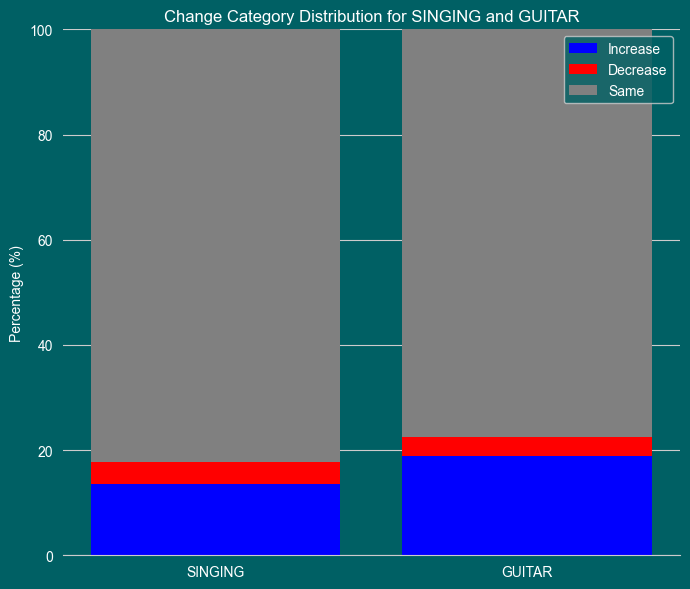

In [12]:
# Calculate the prevalence
total_count = len(df_music)
singing_count = df_music['SINGING'].sum()
drums_count = df_music['GUITAR'].sum()
singing_percentage = (singing_count / total_count) * 100
drums_percentage = (drums_count / total_count) * 100

# Calculate the distribution of change_category for SINGING and DRUMS
singing_distribution = df_music[df_music['SINGING'] == True]['change_category'].value_counts(normalize=True) * 100
drums_distribution = df_music[df_music['GUITAR'] == True]['change_category'].value_counts(normalize=True) * 100

# Visualize the distribution of change_category
fig2, ax2 = plt.subplots(figsize=(7, 6))

singing_increase = singing_distribution.get('Increase', 0)
singing_decrease = singing_distribution.get('Decrease', 0)
singing_same = singing_distribution.get('Same', 0)

drums_increase = drums_distribution.get('Increase', 0)
drums_decrease = drums_distribution.get('Decrease', 0)
drums_same = drums_distribution.get('Same', 0)

ax2.bar('SINGING', singing_increase, label='Increase', color='blue')
ax2.bar('SINGING', singing_decrease, bottom=singing_increase, label='Decrease', color='red')
ax2.bar('SINGING', singing_same, bottom=singing_increase+singing_decrease, label='Same', color='gray')

ax2.bar('GUITAR', drums_increase, color='blue')
ax2.bar('GUITAR', drums_decrease, bottom=drums_increase, color='red')
ax2.bar('GUITAR', drums_same, bottom=drums_increase+drums_decrease, color='gray')

ax2.set_title('Change Category Distribution for SINGING and GUITAR')
ax2.set_ylabel('Percentage (%)')
ax2.set_ylim(0, 100)
ax2.legend()

plt.tight_layout()
plt.show()

## Inferential Analysis
Hypothesis Testing: Conduct hypothesis tests (e.g., t-tests, ANOVA) to determine if there are statistically significant differences in attendance based on different offerings.

In [13]:
# Inferential Analysis

# Select specific features and drop rows with missing target data
df_music_inferential = data[['SINGING', 'CHOIR', 'PIANO', 'ORGAN', 'DRUMS', 'ELECGTR', 'GUITAR', 'change_category']]

# Drop rows with missing target data
df_music_inferential = df_music_inferential.dropna(subset=['change_category'])

# Convert music type columns to categorical
music_types = ['SINGING', 'CHOIR', 'PIANO', 'ORGAN', 'DRUMS', 'ELECGTR', 'GUITAR']
for col in music_types:
    df_music_inferential[col] = df_music_inferential[col].astype('category')

# Check the data
#print(df_music_inferential.head())

# Function to perform Chi-Square test
def perform_chi2_test(df, music_type):
    contingency_table = pd.crosstab(df[music_type], df['change_category'])
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    return chi2_stat, p_val

chi2_results = {music_type: perform_chi2_test(df_music, music_type) for music_type in music_types}

# Display Chi-Square results
for music_type, (chi2_stat, p_val) in chi2_results.items():
    print(f"Chi-Square test for {music_type}: Chi2-statistic = {chi2_stat:.4f}, p-value = {p_val:.4e}")

Chi-Square test for SINGING: Chi2-statistic = 1.5352, p-value = 4.6413e-01
Chi-Square test for CHOIR: Chi2-statistic = 3.2587, p-value = 1.9605e-01
Chi-Square test for PIANO: Chi2-statistic = 0.0000, p-value = 1.0000e+00
Chi-Square test for ORGAN: Chi2-statistic = 0.0000, p-value = 1.0000e+00
Chi-Square test for DRUMS: Chi2-statistic = 18.7812, p-value = 8.3506e-05
Chi-Square test for ELECGTR: Chi2-statistic = 0.0000, p-value = 1.0000e+00
Chi-Square test for GUITAR: Chi2-statistic = 22.4708, p-value = 1.3199e-05


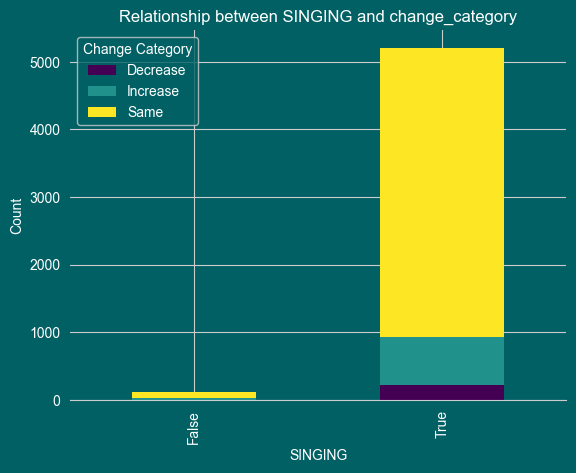

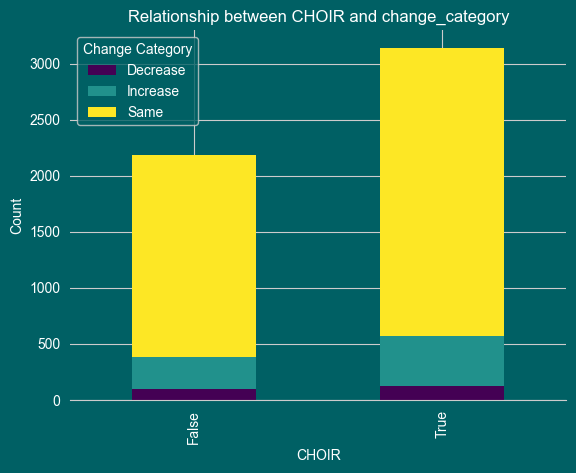

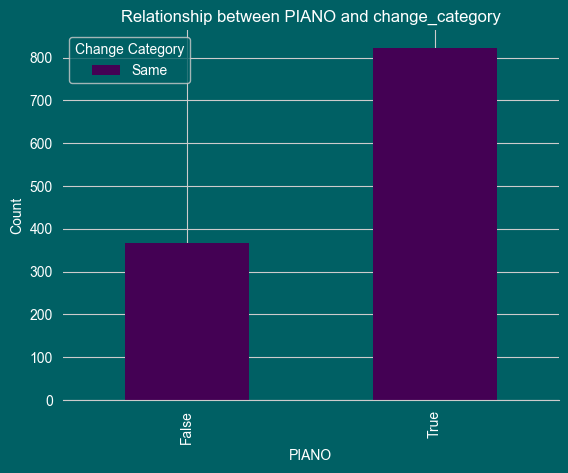

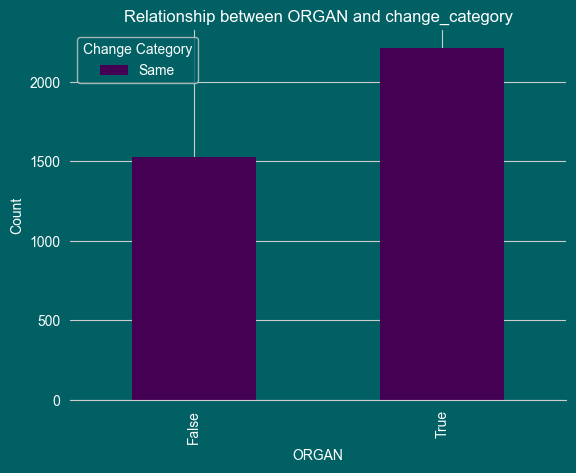

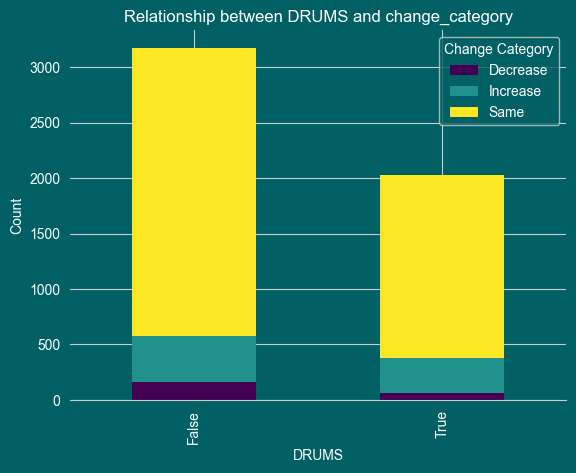

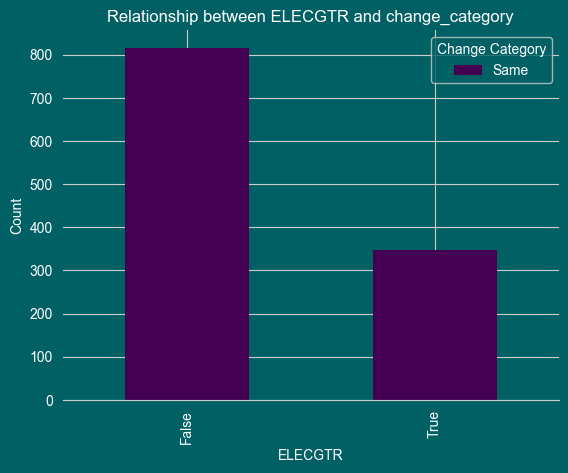

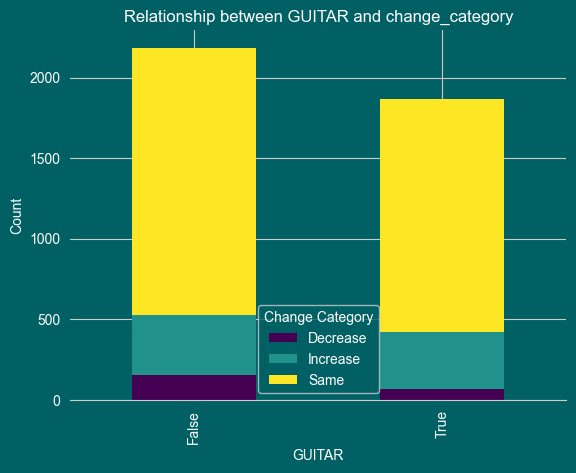

In [14]:
# Function to plot relationship
def plot_relationship(df, music_type):
    contingency_table = pd.crosstab(df[music_type], df['change_category'])
    contingency_table.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title(f'Relationship between {music_type} and change_category')
    plt.xlabel(music_type)
    plt.ylabel('Count')
    plt.legend(title='Change Category')
    plt.show()

# Plot relationships
for music_type in music_types:
    plot_relationship(df_music, music_type)

## Regression Analysis
Linear Regression: Model the relationship between congregational size (dependent variable) and offerings (independent variables) using linear regression.<br>
Logistic Regression: If the outcome is categorical (e.g., increased attendance vs. no increase), use logistic regression.

In [15]:
# Determine NaN value counts in each column
nan_counts = df_music.isnull().sum()
print("NaN value counts in each column:")
print(nan_counts)

NaN value counts in each column:
SINGING               4
CHOIR                 5
PIANO              4143
ORGAN              1591
DRUMS               128
ELECGTR            4170
GUITAR             1285
change_category       0
dtype: int64


In [16]:
# Logistic Regression

# Select specific columns and drop NaN values
df_music_logit = df_music[['SINGING', 'CHOIR', 'DRUMS', 'GUITAR', 'change_category']].dropna()

# One-Hot Encoding for the target variable
df_music_logit['change_category'] = df_music_logit['change_category'].astype('category')
encoder = OneHotEncoder(sparse_output=False)
encoded_target = encoder.fit_transform(df_music_logit[['change_category']])
encoded_target_df = pd.DataFrame(encoded_target, columns=encoder.get_feature_names_out(['change_category']))

# Merge encoded target with the main dataframe and drop the original target column
df_music_logit = pd.concat([df_music_logit.reset_index(drop=True), encoded_target_df], axis=1)
df_music_logit.drop(['change_category'], axis=1, inplace=True)

# Encode the target variable for Random Forest
target = df_music_logit['change_category_Increase']
df_music_logit.drop(['change_category_Increase', 'change_category_Decrease', 'change_category_Same'], axis=1, inplace=True)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_music_logit, target, test_size=0.3, random_state=42)

# Train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict the test set results
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Optional: Feature importance
feature_importance = pd.Series(model.coef_[0], index=X_train.columns).sort_values(ascending=False)
print("Feature Importance:")
print(feature_importance)

Accuracy: 0.830997526793075
Confusion Matrix:
[[1008    0]
 [ 205    0]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91      1008
         1.0       0.00      0.00      0.00       205

    accuracy                           0.83      1213
   macro avg       0.42      0.50      0.45      1213
weighted avg       0.69      0.83      0.75      1213

Feature Importance:
CHOIR      0.304059
GUITAR     0.176492
DRUMS     -0.051140
SINGING   -0.864145
dtype: float64


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Multivariate Analysis
Multiple Regression: Extend linear regression to include multiple independent variables to account for the effect of various factors simultaneously.<br>
Principal Component Analysis (PCA): Reduce dimensionality and identify key factors contributing to attendance changes.

## Time Series Analysis
Trend Analysis: Examine how congregational size and offerings have changed over time.<br>
Seasonality: Identify seasonal patterns in attendance.

## Predictive Analysis
Machine Learning Models: Implement machine learning models (e.g., decision trees, random forests, gradient boosting) to predict attendance based on congregational offerings.<br>
Model Evaluation: Use cross-validation and performance metrics (e.g., RMSE, AUC) to assess model accuracy.

In [17]:
# Random Forest

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_smote, y_train_smote)

# Predict the test set results
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Optional: Feature importance
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Feature Importance:")
print(feature_importance)

Accuracy: 0.517724649629019
Confusion Matrix:
[[517 491]
 [ 94 111]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.51      0.64      1008
         1.0       0.18      0.54      0.28       205

    accuracy                           0.52      1213
   macro avg       0.52      0.53      0.46      1213
weighted avg       0.73      0.52      0.58      1213

Feature Importance:
CHOIR      0.386506
SINGING    0.240209
GUITAR     0.224312
DRUMS      0.148973
dtype: float64


## Causal Analysis
Causal Inference: Use methods like propensity score matching or instrumental variables to identify causal relationships between offerings and attendance.

## Recommendations
Actionable Insights: Provide recommendations based on the analysis, highlighting which factors most significantly influence attendance.<br>
Scenario Analysis: Simulate different scenarios to predict the impact of changes in offerings on attendance.